# Tree Species Classification in Orthoimages of Brandenburg

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import math
import matplotlib.pyplot as plt
import rasterio
import sys
from pathlib import Path
from typing import List, Dict

import torch
from torch import permute, nan_to_num
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as transforms

from trees_brandenburg import preprocess, plotting
from trees_brandenburg.modelling import train, inference

## Data Overview

The goal of this notebook is develop a CNN from which can classify different tree species in orthoimages. The data used are orthoimages from Brandenburg from different years and seasons. For more detail about the images, see [here](https://geobroker.geobasis-bb.de/gbss.php?MODE=GetProductInformation&PRODUCTID=253b7d3d-6b42-47dc-b127-682de078b7ae).
All images with a resolution of 20cm were downloaded and further processed into final image tiles of 100px by 100px.

The table below shows the number of training samples per tree species. The most dominant species by is the *Pinus sylvestris*, followed by *Alnus rubra* and *Quercus robur*. The dataset contains 33 different species. In a first effort however, we're only trying to clssify the five most prominent ones.

To make our lives easier, the raw data (`data/raw`) is renamed and moved into a different folder (`data/processed`).

| **Species** | **Number of training samples** |
|:-----------:|--------------------------------|
| GKI         | 201633                         |
| RER         | 5876                           |
| SEI         | 2834                           |
| GBI         | 2482                           |
| TEI         | 2169                           |
| GDG         | 1893                           |
| RBU         | 1741                           |
| ELA         | 1524                           |
| REI         | 1305                           |
| GFI         | 1186                           |
| PAS         | 599                            |
| RO          | 435                            |
| EI          | 315                            |
| BPA         | 217                            |
| BAH         | 191                            |
| JLA         | 169                            |
| WKI         | 145                            |
| WEB         | 114                            |
| SKI         | 101                            |
| WLI         | 86                             |
| KTA         | 78                             |
| SAH         | 71                             |
| AS          | 59                             |
| HBU         | 58                             |
| WLS         | 34                             |
| HLS         | 31                             |
| WER         | 26                             |
| GES         | 25                             |
| STK         | 22                             |
| BFI         | 17                             |
| SFI         | 13                             |
| EIS         | 13                             |
| HPA         | 12                             |

In [2]:
class_subset: List[str] = ["GKI", "RER", "SEI", "GBI", "TEI"]
src: Path = Path("../data/raw")
subset: Path = Path("../data/processed/imgs")
preprocess.generate_subset(src, subset, class_subset)

data = preprocess.generate_data_overview(subset)
data.head()

E:\trees-brandenburg\trees_brandenburg\preprocess.py:33: UserWarning: Directory ..\data\processed/GBI or some part of it already exists. No data was copied for this class
  warn(f"Directory {outdir}/{stem} or some part of it already exists. No data was copied for this class")
E:\trees-brandenburg\trees_brandenburg\preprocess.py:33: UserWarning: Directory ..\data\processed/GKI or some part of it already exists. No data was copied for this class
  warn(f"Directory {outdir}/{stem} or some part of it already exists. No data was copied for this class")
E:\trees-brandenburg\trees_brandenburg\preprocess.py:33: UserWarning: Directory ..\data\processed/RER or some part of it already exists. No data was copied for this class
  warn(f"Directory {outdir}/{stem} or some part of it already exists. No data was copied for this class")
E:\trees-brandenburg\trees_brandenburg\preprocess.py:33: UserWarning: Directory ..\data\processed/SEI or some part of it already exists. No data was copied for this clas

,images,labels,encoded_labels
0,E:\trees-brandenburg\data\processed\GBI\dop_33...,GBI,0
1,E:\trees-brandenburg\data\processed\GBI\dop_33...,GBI,0
2,E:\trees-brandenburg\data\processed\GBI\dop_33...,GBI,0
3,E:\trees-brandenburg\data\processed\GBI\dop_33...,GBI,0
4,E:\trees-brandenburg\data\processed\GBI\dop_33...,GBI,0


## Setup Trainig

Define key-parameters for the training of the deep learning model. This is required early in the code as for example batch size is needed to define the DataLoader in the correct way.


In [3]:
device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size: int = 128
validation_split: float = .3
shuffle_dataset: bool = True
random_seed: int = 42
n_epochs: int = 20

Prepare the data split and create data loaders that will allow you to load the data into the model training process.

In [4]:
dataset_size: int = len(data)
indices: List[int] = list(range(dataset_size))
split: int = int(math.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
training_sampler, validation_sampler = SubsetRandomSampler(indices[split:]), SubsetRandomSampler(indices[:split])

Define data transformations and create a Pytorch dataset class instance

In [5]:
transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = train.TreeSpeciesClassificationDataset(data, transform)

Create a Dataloader for the training dataset.

In [6]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=training_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)

We do some plotting

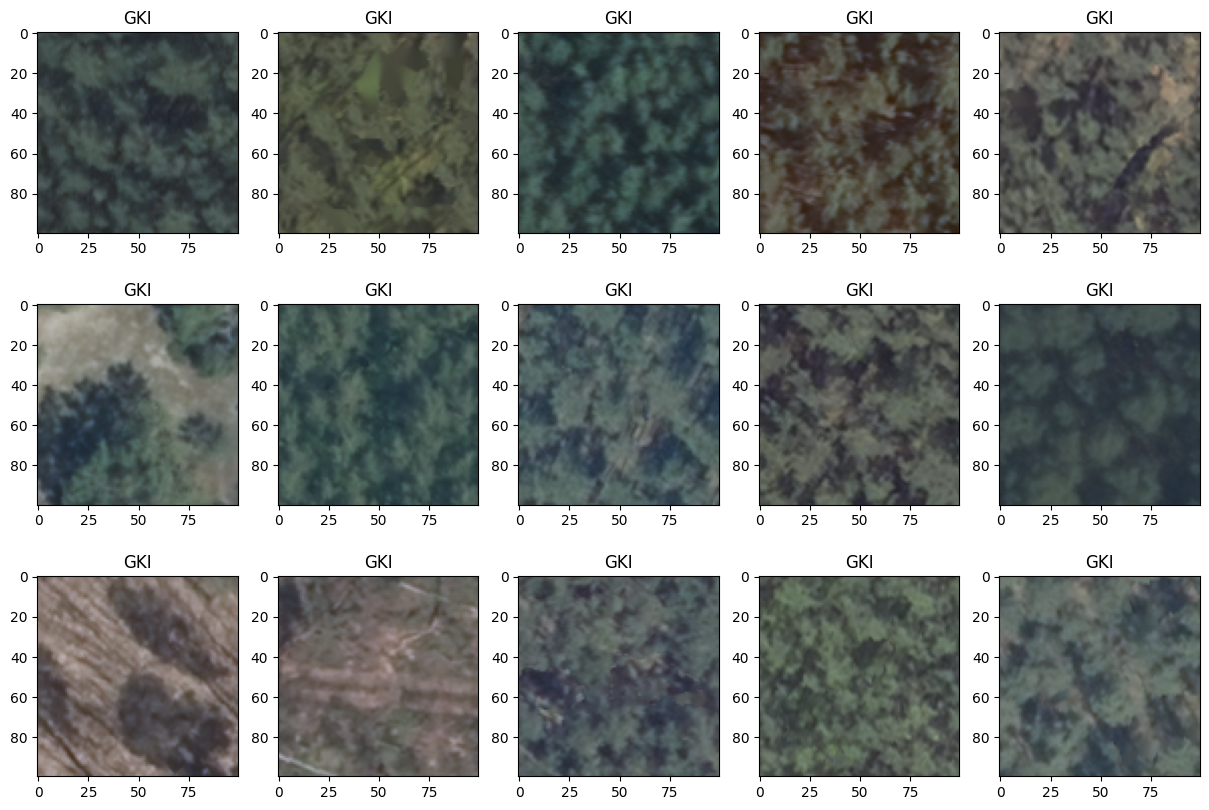

In [7]:
reverse_labels: Dict[int, str] = data[["encoded_labels", "labels"]].drop_duplicates(ignore_index=True).to_dict()["labels"]
fig, ax = plotting.plot_images(train_loader, reverse_labels, figsize=(15, 10))

Instantiate the model and set up our optimizer. Here, we also adjust the weights (not fully understood by me) to work with imbalanced classes.

In [8]:
cnn_model = train.CNN()

num_samples = np.empty((len(class_subset),))
num_samples[data.encoded_labels.value_counts().index.values] = data.encoded_labels.value_counts().values
weights = 1.0 / num_samples
normalized_weights = weights / np.sum(weights) # norm to 1

criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(normalized_weights).float())
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)

In [ ]:
print_every = 10
valid_loss_min = np.inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)

FINAL_MODEL_PATH: Path = Path("../data/processed") / 'model_scripted.pt'

for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        optimizer.zero_grad() # zero the parameter gradients
        # forward + backward + optimize
        outputs = cnn_model(data_)
        loss = criterion(outputs, target_.long())
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        correct += train.accuracy(outputs, target_)
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    cnn_model.eval()
    with torch.inference_mode():
        for data_t, target_t in (validation_loader):
            outputs_t = cnn_model(data_t)
            loss_t = criterion(outputs_t, target_t.long())
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min  # FIXME is this correct?
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(cnn_model.state_dict(), Path("../data/processed") / 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    cnn_model.train()

model_scripted = torch.jit.script(cnn_model)
model_scripted.save(FINAL_MODEL_PATH)

Epoch 1

Epoch [1/20], Step [0/1176], Loss: 2.0768
Epoch [1/20], Step [20/1176], Loss: 1.2138
Epoch [1/20], Step [40/1176], Loss: 1.1770
Epoch [1/20], Step [60/1176], Loss: 1.4721
Epoch [1/20], Step [80/1176], Loss: 1.3425
Epoch [1/20], Step [100/1176], Loss: 1.2226
Epoch [1/20], Step [120/1176], Loss: 1.0652
Epoch [1/20], Step [140/1176], Loss: 1.5821
Epoch [1/20], Step [160/1176], Loss: 1.5391
Epoch [1/20], Step [180/1176], Loss: 1.3677
Epoch [1/20], Step [200/1176], Loss: 1.1550
Epoch [1/20], Step [220/1176], Loss: 1.4581
Epoch [1/20], Step [240/1176], Loss: 1.3334
Epoch [1/20], Step [260/1176], Loss: 1.5482
Epoch [1/20], Step [280/1176], Loss: 0.9647
Epoch [1/20], Step [300/1176], Loss: 1.1919
Epoch [1/20], Step [320/1176], Loss: 0.9957
Epoch [1/20], Step [340/1176], Loss: 1.1348
Epoch [1/20], Step [360/1176], Loss: 1.0990
Epoch [1/20], Step [380/1176], Loss: 1.3478
Epoch [1/20], Step [400/1176], Loss: 1.5230
Epoch [1/20], Step [420/1176], Loss: 1.1378
Epoch [1/20], Step [440/1176]

## Post-Training

After we're done with the model trainin, let us plot both the training/validation loss and accuracy.

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

### Plotting Validation

Why exactly are we plotting the validation data here? Whatever...

In [ ]:
model = torch.jit.load(FINAL_MODEL_PATH)
model.eval()

fig, ax = plotting.plot_validation(train_loader, model, reverse_labels, figsize=(15, 10))